# 加载依赖

In [1]:
import get_data as data
from torch.utils.data import  Dataset,random_split,DataLoader
import torch.nn as nn
import utile
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# 超参数

In [2]:
lr = 0.0005
batch_size=128
num_worker = 0
epoch_num=400

# 加载数据集

In [3]:
t = data.TrafficDataset()
train_set, val_set, test_set = t.construct_set(window_size=12,label=1)
train_loader = DataLoader(train_set,batch_size=batch_size,shuffle=True,num_workers=num_worker,drop_last=True)
val_loader = DataLoader(val_set,batch_size=batch_size,shuffle=True,num_workers=num_worker,drop_last=True)
test_loader = DataLoader(test_set,batch_size=batch_size,shuffle=True,num_workers=num_worker,drop_last=True)

(17856, 170, 3)


E:\毕设文件\DeepLearning\experiment04\get_data.py:69: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:248.)
  train_set = my_Dataset(torch.Tensor(train_x), torch.Tensor(train_y))


# RNN
## 手动实现RNN
### 手动实现框架

In [4]:
class MyRnn(nn.Module):
    def __init__(self,input_size,hidden_size,output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.w_h = nn.Parameter(torch.rand(input_size,hidden_size))
        self.u_h = nn.Parameter(torch.rand(hidden_size,hidden_size))
        self.b_h =nn.Parameter(torch.zeros(hidden_size))

        self.w_y = nn.Parameter(torch.rand(hidden_size,output_size))
        self.b_y = nn.Parameter(torch.zeros(output_size))

        self.tanh = nn.Tanh()
        self.leaky_relu = nn.LeakyReLU()

        for param in self.parameters():
            if param.dim()>1:
                nn.init.xavier_uniform_(param)
    def forward(self,x):
        x = x.to(device)
        batch_size = x.size(0)
        seq_len = x.size(1)

        h  = torch.zeros(batch_size,self.hidden_size).to(device)

        y_list = []
        for i  in range(seq_len):
            h  = self.tanh(torch.matmul(x[:,i,:],self.w_h)+
                           torch.matmul(h,self.u_h)+self.b_h)
            y = self.leaky_relu(
                torch.matmul(h,self.w_y)+self.b_y
            )
            y_list.append(y)
        return torch.stack(y_list,dim=1),h

### 手动实现RNN训练与评估

epoch: 1 
 train_loss: 4.685968165806818e-06 test_loss: 1.8188557246671902e-06 val_loss: 1.8136213468635645e-06 
 mae: 2.0879548 rmse: 2.1840289022224826
epoch: 2 
 train_loss: 8.890509041997662e-07 test_loss: 8.293869452952802e-07 val_loss: 8.581857371239123e-07 
 mae: 1.2980784 rmse: 1.4349579380149777
epoch: 3 
 train_loss: 6.427624573420707e-07 test_loss: 6.314149935086014e-07 val_loss: 6.049021429269622e-07 
 mae: 1.1867386 rmse: 1.2572390666297977
epoch: 4 
 train_loss: 3.973316494348621e-07 test_loss: 3.7750359638266673e-07 val_loss: 3.2294954200585416e-07 
 mae: 0.88490295 rmse: 0.921594960754956
epoch: 5 
 train_loss: 2.3030125062684628e-07 test_loss: 2.6107638164931916e-07 val_loss: 2.400218187824942e-07 
 mae: 0.74402833 rmse: 0.7890017959725035
epoch: 6 
 train_loss: 2.0810999527146078e-07 test_loss: 3.2917122367777027e-07 val_loss: 3.256747649831798e-07 
 mae: 0.89117306 rmse: 0.9255429068021519
epoch: 7 
 train_loss: 1.453025238549525e-07 test_loss: 1.19402645598004e-07 v

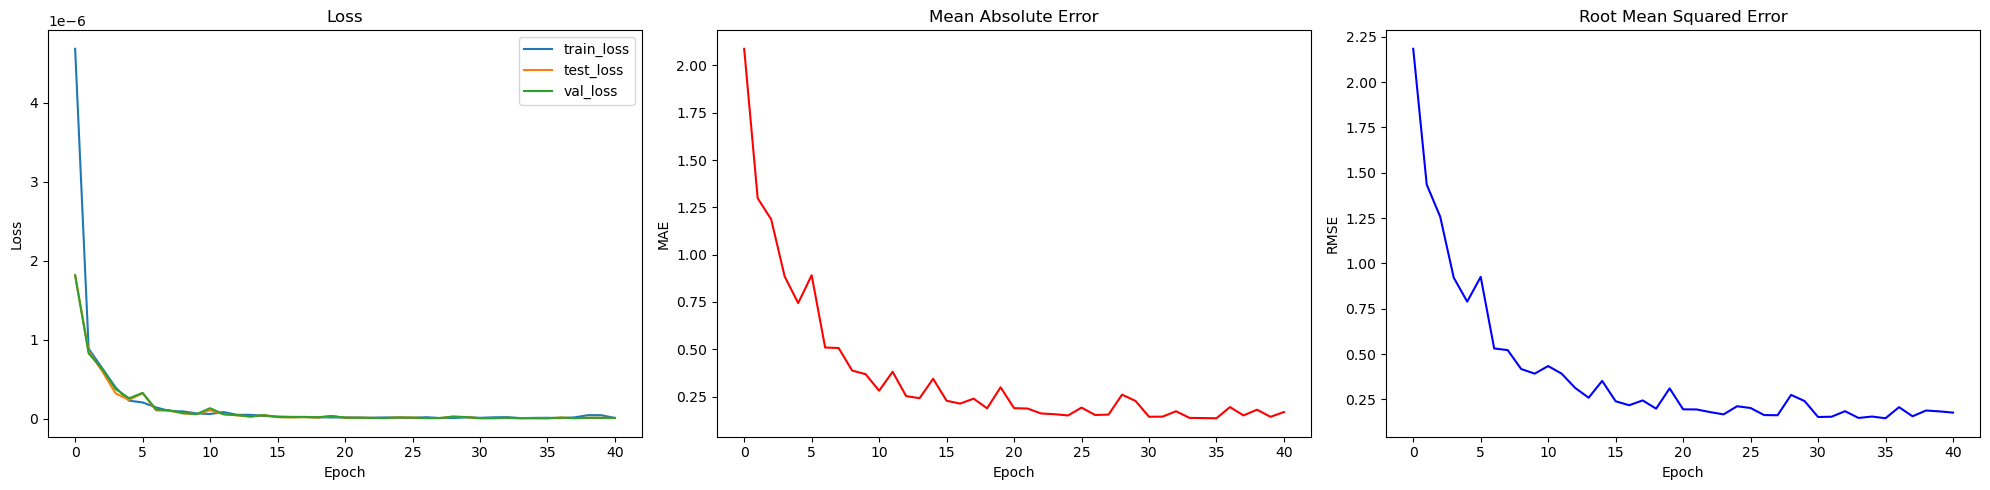

In [5]:
train_loss,val_loss,test_loss,mae,rmse=utile.train(t.denormalize,torch.optim.Adam,lr,torch.nn.HuberLoss(delta=2),MyRnn(3,64,1),train_loader,val_loader,test_loader,epoch_num,device,batch_size,early_stop_len=5)
utile.show_result(train_loss,val_loss,test_loss,mae,rmse)

## 框架实现RNN
### 训练与评估

epoch: 1 
 train_loss: 6.760888078459398e-07 test_loss: 3.8698940506441835e-07 val_loss: 3.8721600082714794e-07 
 mae: 1.0088567 rmse: 1.0093779735894859
epoch: 2 
 train_loss: 2.517173970841487e-07 test_loss: 1.0159428801107087e-07 val_loss: 1.0156027011968642e-07 
 mae: 0.5159023 rmse: 0.5169320858606499
epoch: 3 
 train_loss: 2.868853703994291e-08 test_loss: 1.3095737334051844e-08 val_loss: 1.231536038580493e-08 
 mae: 0.17239946 rmse: 0.1788351261888825
epoch: 4 
 train_loss: 1.0303556219738936e-08 test_loss: 1.300612036177258e-08 val_loss: 1.1818581339921533e-08 
 mae: 0.16417444 rmse: 0.17328160202251847
epoch: 5 
 train_loss: 1.0374269978549967e-08 test_loss: 1.3164413789520832e-08 val_loss: 1.1634688932447177e-08 
 mae: 0.15947534 rmse: 0.16999343181888016
epoch: 6 
 train_loss: 9.71183853016692e-09 test_loss: 1.3857659908467213e-08 val_loss: 1.1757010410496638e-08 
 mae: 0.15269929 rmse: 0.1667725561063016
epoch: 7 
 train_loss: 1.0967872083102131e-08 test_loss: 1.279443343041

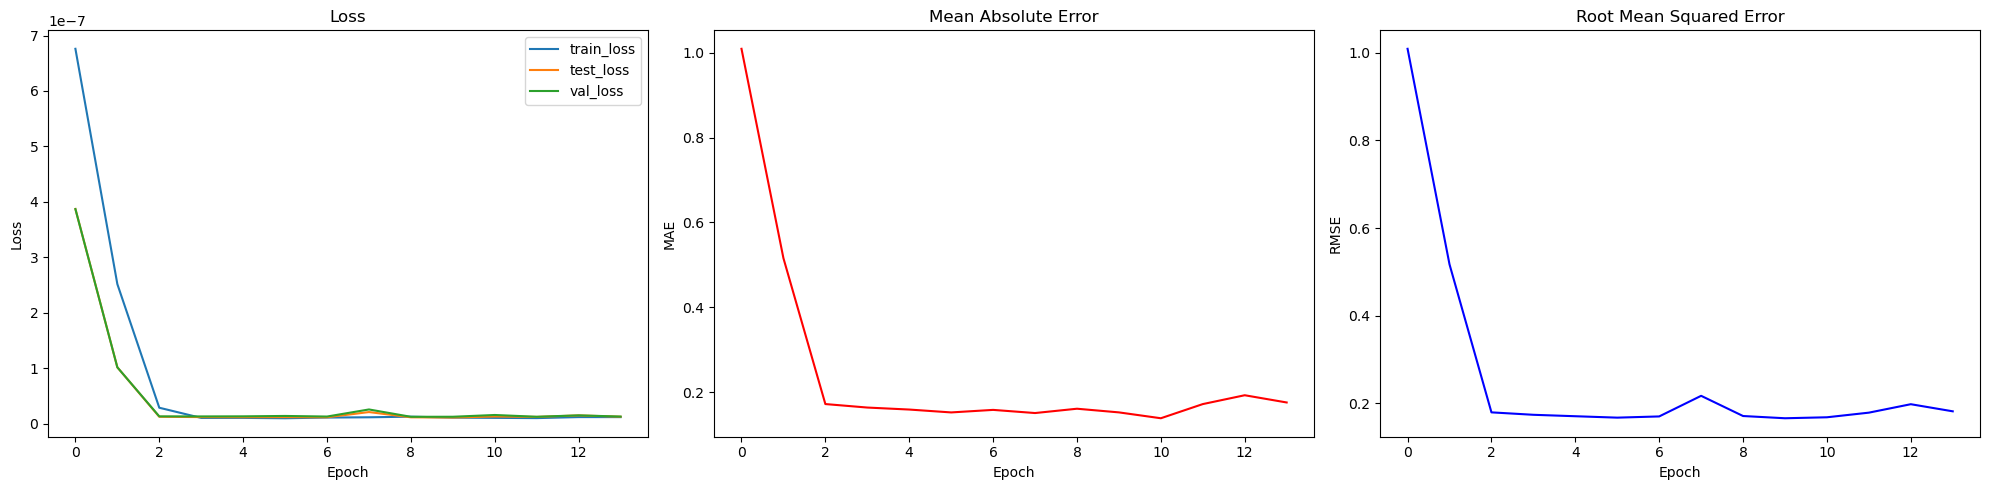

In [6]:
train_loss,val_loss,test_loss,mae,rmse=utile.train(t.denormalize,torch.optim.Adam,lr,torch.nn.HuberLoss(delta=2),nn.RNN(3,64,1,batch_first=True),train_loader,val_loader,test_loader,epoch_num,device,batch_size,early_stop_len=5,output_model=nn.Sequential(nn.Linear(64, 1),nn.LeakyReLU()).to(device))
utile.show_result(train_loss,val_loss,test_loss,mae,rmse)

## 实验结果对比

# LSTM部分
## 手动实现LSTM代码
### 手动实现框架代码

In [7]:
class MyLstm(nn.Module):
    def __init__(self,input_size,hidden_size):
        super().__init__()
        self.hidden_size = hidden_size

        self.gates = nn.Linear(input_size+hidden_size,hidden_size*4)
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()

        for param in self.parameters():
            if param.dim()>1:
                nn.init.xavier_uniform_(param)
    def forward(self,x):
        x = x.to(device)
        batch_size = x.size(0)
        seq_len = x.size(1)

        h,c = (torch.zeros(batch_size,self.hidden_size).to(device) for _ in range(2))
        y_list=[]
        for i in range(seq_len):
            forget_gate,input_gate,output_gate,candidate_cell = self.gates(torch.cat([x[:,i,:],h],dim=-1)).chunk(4,-1)
            forget_gate,input_gate,output_gate=(self.sigmoid(g) for g in (forget_gate,input_gate,output_gate))
            c = forget_gate * c +input_gate*self.tanh(candidate_cell)
            h = output_gate*self.tanh(c)
            y_list.append(h[:,-1].view(batch_size,-1))
        return torch.stack(y_list,dim=1),(h,c)

### 训练与评估

epoch: 1 
 train_loss: 7.656813067339488e-06 test_loss: 2.827827301046084e-07 val_loss: 3.255148744461554e-07 
 mae: 0.7114969 rmse: 0.9223001829545865
epoch: 2 
 train_loss: 2.5769481473468977e-07 test_loss: 2.467813381464886e-07 val_loss: 2.944466070141937e-07 
 mae: 0.6301324 rmse: 0.8751110675485448
epoch: 3 
 train_loss: 2.470906677551711e-07 test_loss: 2.3712644239940009e-07 val_loss: 2.8275258888175747e-07 
 mae: 0.62329 rmse: 0.8584675642672492
epoch: 4 
 train_loss: 2.3699905528312492e-07 test_loss: 2.2819141591938847e-07 val_loss: 2.7043771955993215e-07 
 mae: 0.6038061 rmse: 0.8412139247509562
epoch: 5 
 train_loss: 2.2774152341753506e-07 test_loss: 2.1879101131650747e-07 val_loss: 2.5808552463870537e-07 
 mae: 0.59459585 rmse: 0.8206093917991573
epoch: 6 
 train_loss: 2.1622708849660618e-07 test_loss: 2.0814653585906248e-07 val_loss: 2.471466844840338e-07 
 mae: 0.5845275 rmse: 0.802251976531699
epoch: 7 
 train_loss: 2.0499956884901095e-07 test_loss: 2.0080493278050602e-07

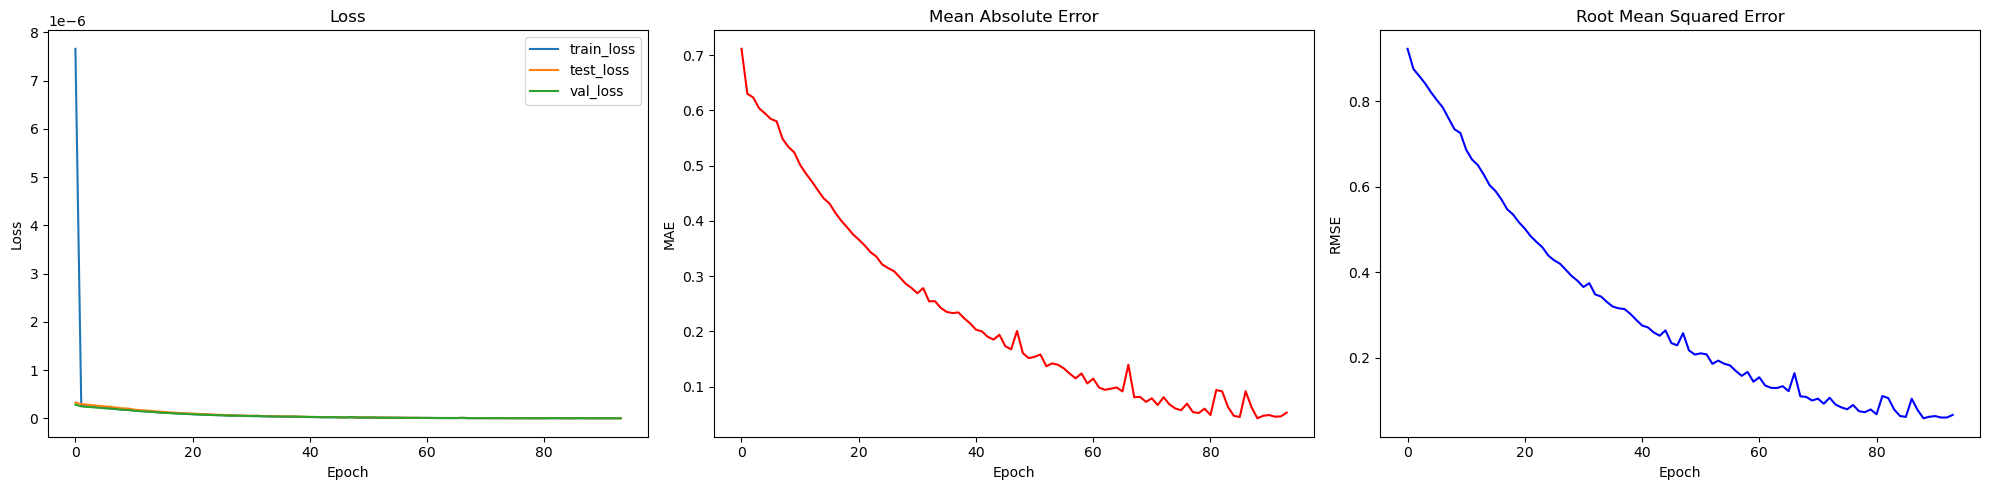

In [8]:
train_loss,val_loss,test_loss,mae,rmse=utile.train(t.denormalize,torch.optim.Adam,lr,torch.nn.HuberLoss(delta=2),MyLstm(3,64),train_loader,val_loader,test_loader,epoch_num,device,batch_size,early_stop_len=5)
utile.show_result(train_loss,val_loss,test_loss,mae,rmse)

## 框架实现LSTM代码
### 框架代码

In [9]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        seq_len = x.size(1)
        # out = self.fc(out[:, -1, :])  # 取最后一个时间步的输出
        # print(out[:,:,-1].view(batch_size,seq_len,-1).size())
        return out[:,:,-1].view(batch_size,seq_len,-1),_

### 训练与评估

epoch: 1 
 train_loss: 1.986704782176133e-05 test_loss: 7.674599689582667e-07 val_loss: 8.185200920673163e-07 
 mae: 1.1797414 rmse: 1.4626732270057687
epoch: 2 
 train_loss: 5.073922963389802e-07 test_loss: 4.689475021964258e-07 val_loss: 5.431526506914384e-07 
 mae: 0.8694393 rmse: 1.1910728421667285
epoch: 3 
 train_loss: 4.5865862463311297e-07 test_loss: 4.4192402297253634e-07 val_loss: 5.063730796977055e-07 
 mae: 0.83179086 rmse: 1.145608950820218
epoch: 4 
 train_loss: 4.252055490784428e-07 test_loss: 4.1091341266244986e-07 val_loss: 4.705791714817072e-07 
 mae: 0.813464 rmse: 1.1062133880120488
epoch: 5 
 train_loss: 3.905184481010954e-07 test_loss: 3.7034868051301197e-07 val_loss: 4.3312089217208804e-07 
 mae: 0.7678391 rmse: 1.062556079701619
epoch: 6 
 train_loss: 3.6136950434438513e-07 test_loss: 3.537671941726499e-07 val_loss: 4.059324838736858e-07 
 mae: 0.77003825 rmse: 1.0281324754842682
epoch: 7 
 train_loss: 3.308937814299169e-07 test_loss: 3.259076935238328e-07 val_l

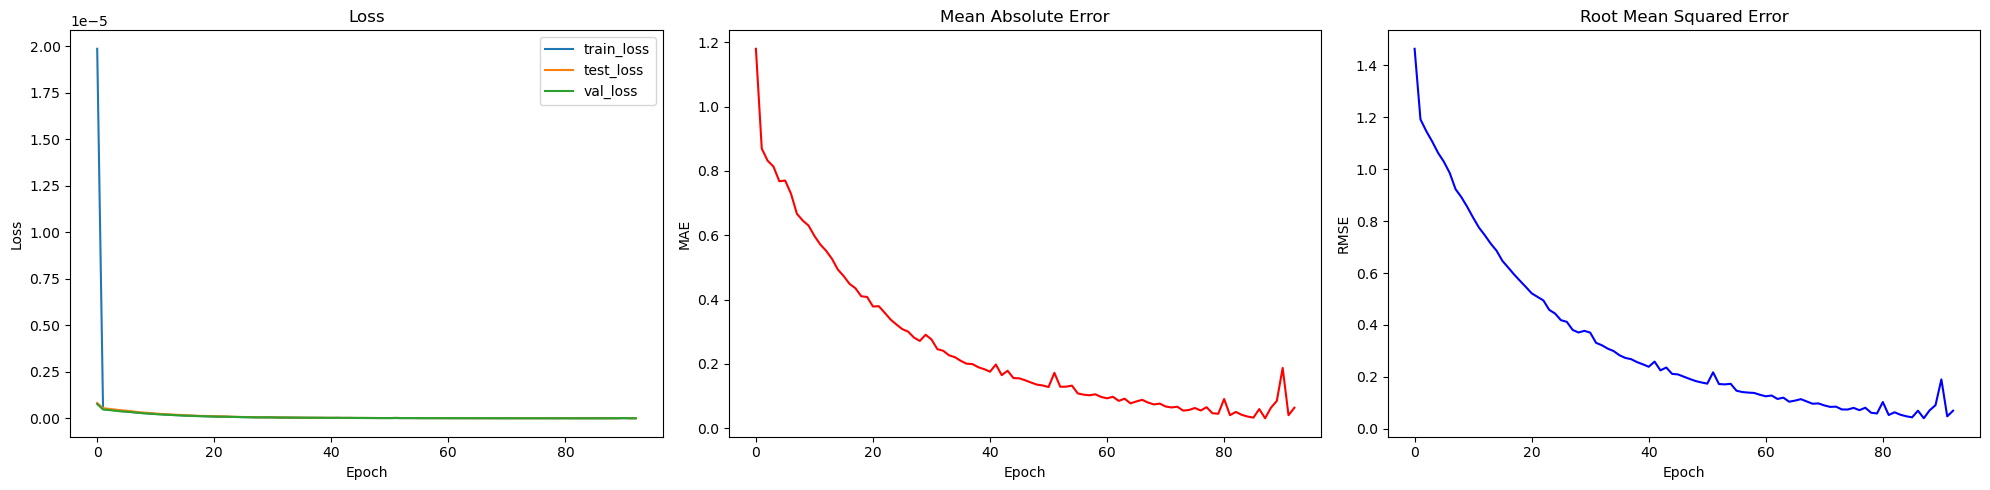

In [10]:
train_loss,val_loss,test_loss,mae,rmse=utile.train(t.denormalize,torch.optim.Adam,lr,torch.nn.HuberLoss(delta=2),LSTMModel(3,64,1,1),train_loader,val_loader,test_loader,epoch_num,device,batch_size,early_stop_len=5)
utile.show_result(train_loss,val_loss,test_loss,mae,rmse)

## 实验结果分析




# Gru
## 手动实现GRU
### 手动代码实现

In [11]:
class MyGru(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size

        self.gates = nn.Linear(input_size+hidden_size, hidden_size*2)
        # 用于计算candidate hidden state
        self.hidden_transform = nn.Linear(input_size+hidden_size, hidden_size)

        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()

        self.output = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, output_size)
        )

        for param in self.parameters():
            if param.dim() > 1:
                nn.init.xavier_uniform_(param)

    def forward(self, x):
        batch_size = x.size(0)
        seq_len = x.size(1)

        h = torch.zeros(batch_size, self.hidden_size).to(x.device)
        y_list = []
        for i in range(seq_len):
            update_gate, reset_gate = self.gates(torch.cat([x[:, i, :], h], dim=-1)).chunk(2, -1)
            update_gate, reset_gate = (self.sigmoid(gate) for gate in (update_gate, reset_gate))
            candidate_hidden = self.tanh(self.hidden_transform(torch.cat([x[:, i, :], reset_gate * h], dim=-1)))
            h = (1-update_gate) * h + update_gate * candidate_hidden
            y_list.append(self.output(h))
        return torch.stack(y_list, dim=1), h


### 手动代码评估

epoch: 1 
 train_loss: 0.0008418070340733074 test_loss: 8.191248576218236e-07 val_loss: 1.0383113291296737e-06 
 mae: 1.2736121 rmse: 1.6471962785408
epoch: 2 
 train_loss: 1.136624529907015e-06 test_loss: 7.015005099607084e-07 val_loss: 9.234635951071579e-07 
 mae: 1.1917089 rmse: 1.548559289091898
epoch: 3 
 train_loss: 9.570068135439302e-07 test_loss: 6.421386876388203e-07 val_loss: 8.127158716214817e-07 
 mae: 1.1217633 rmse: 1.4581585028428365
epoch: 4 
 train_loss: 8.181221402077404e-07 test_loss: 4.4832106553898213e-07 val_loss: 6.661098763271622e-07 
 mae: 0.95800126 rmse: 1.3134519588942697
epoch: 5 
 train_loss: 7.0072943380325e-07 test_loss: 3.470952747277436e-07 val_loss: 5.604223413566043e-07 
 mae: 0.84109116 rmse: 1.2038656251903848
epoch: 6 
 train_loss: 6.126393242243192e-07 test_loss: 3.2437326753838365e-07 val_loss: 5.100942741120418e-07 
 mae: 0.79736173 rmse: 1.1502532372453105
epoch: 7 
 train_loss: 5.533779708950686e-07 test_loss: 2.697807291143464e-07 val_loss: 

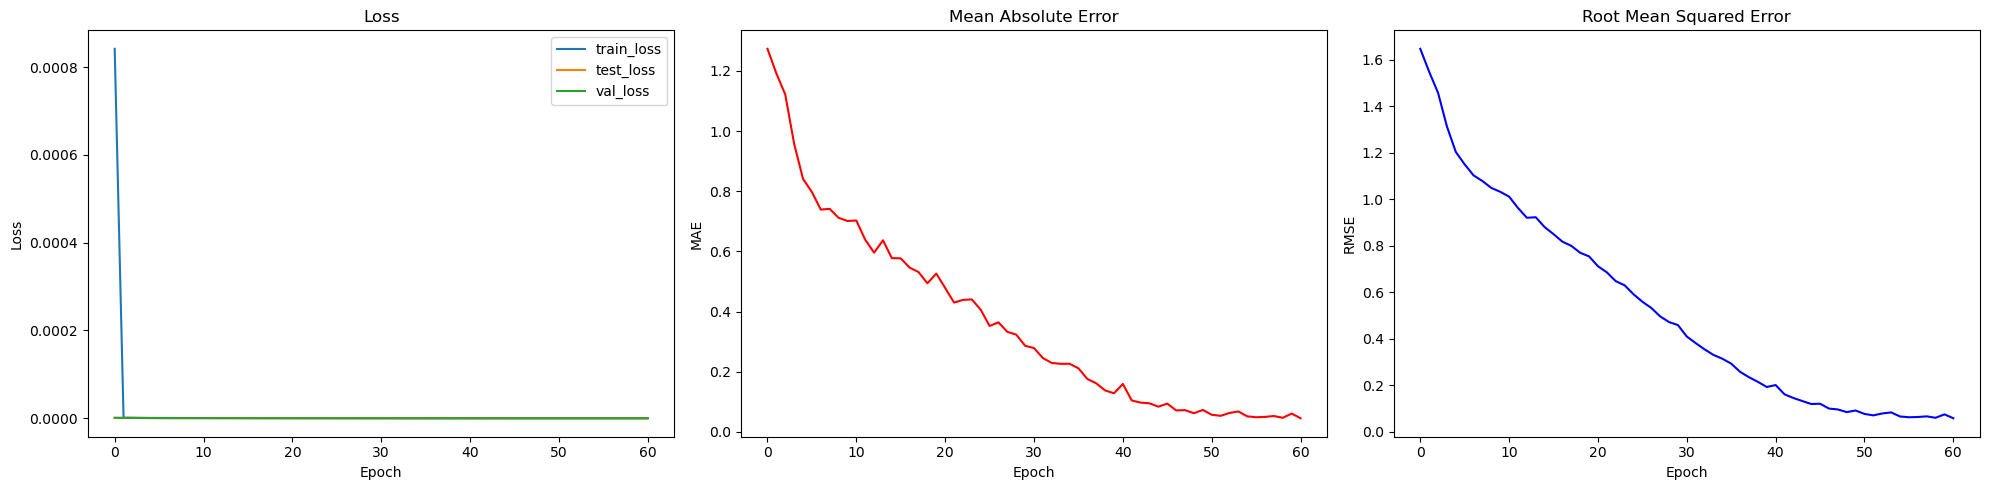

In [12]:

train_loss,val_loss,test_loss,mae,rmse=utile.train(t.denormalize,torch.optim.Adam,lr,torch.nn.HuberLoss(delta=2),MyGru(3,64,1),train_loader,val_loader,test_loader,epoch_num,device,batch_size,early_stop_len=5)
utile.show_result(train_loss,test_loss,val_loss,mae,rmse)

## GRU nn 框架实现
### 框架代码实现与评估

epoch: 1 
 train_loss: 1.070720103530289e-07 test_loss: 8.002103499991251e-08 val_loss: 7.983990739317219e-08 
 mae: 0.45541254 rmse: 0.45832177695122134
epoch: 2 
 train_loss: 5.569264340729808e-08 test_loss: 3.667412500434424e-08 val_loss: 3.6448711768941765e-08 
 mae: 0.30567563 rmse: 0.309654982969948
epoch: 3 
 train_loss: 2.278077563804244e-08 test_loss: 1.3539142185981779e-08 val_loss: 1.3284075864008729e-08 
 mae: 0.18080063 rmse: 0.18692082547159605
epoch: 4 
 train_loss: 7.474177346645353e-09 test_loss: 3.2713817580779883e-09 val_loss: 3.585066860662462e-09 
 mae: 0.08173828 rmse: 0.09691333333244956
epoch: 5 
 train_loss: 4.94150693857807e-09 test_loss: 6.303142370185284e-09 val_loss: 6.121189727931803e-09 
 mae: 0.11734106 rmse: 0.1268418587185192
epoch: 6 
 train_loss: 7.66761374072326e-09 test_loss: 9.982190350030948e-09 val_loss: 9.777377788058975e-09 
 mae: 0.15289897 rmse: 0.16035151596718808
epoch: 7 
 train_loss: 7.3287927266399066e-09 test_loss: 6.551084316994446e-0

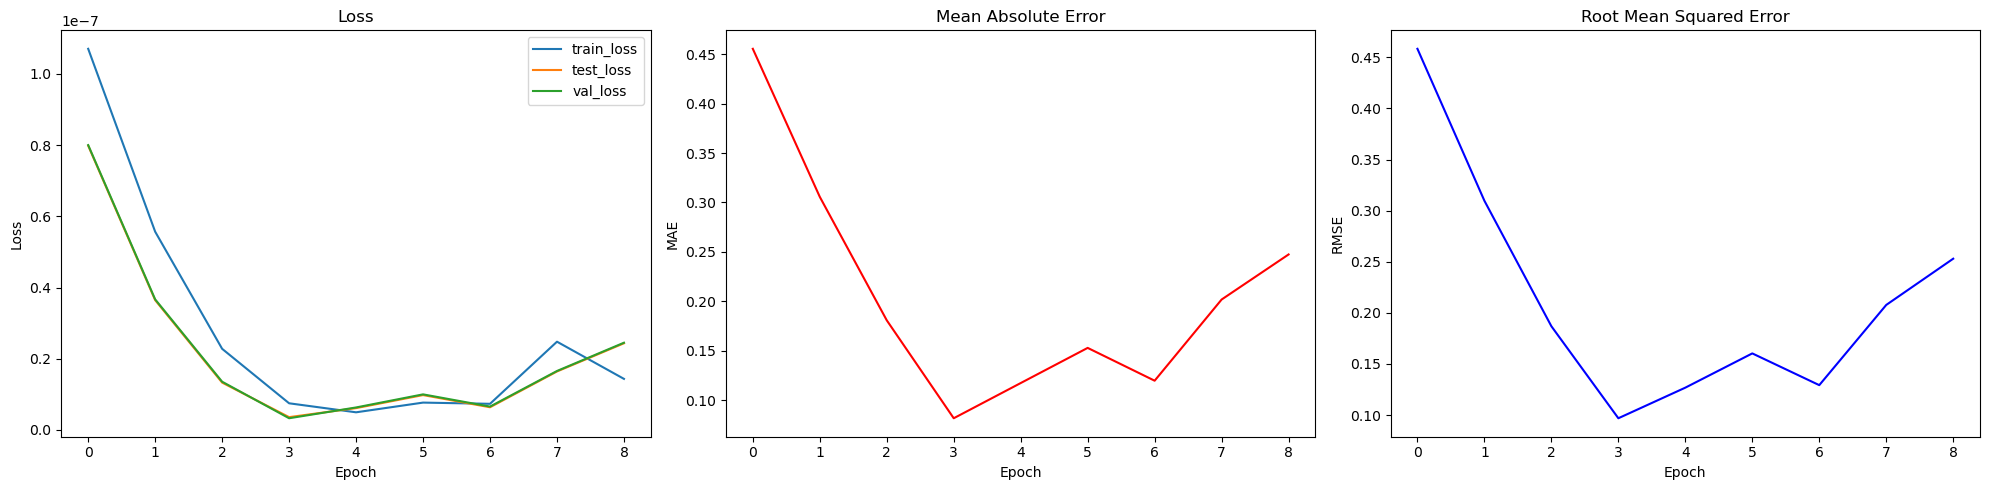

In [13]:
train_loss,val_loss,test_loss,mae,rmse=utile.train(t.denormalize,torch.optim.Adam,lr,torch.nn.HuberLoss(delta=2),nn.GRU(3,64,1,batch_first=True),train_loader,val_loader,test_loader,epoch_num,device,batch_size,early_stop_len=5,output_model=nn.Sequential(nn.Linear(64, 1),nn.LeakyReLU()).to(device))
utile.show_result(train_loss,val_loss,test_loss,mae,rmse)

## 实验结果分析

# 超参数对比
## LSTM对照组

epoch: 1 
 train_loss: 0.00036894484566735365 test_loss: 8.874829375229268e-06 val_loss: 8.656898764322116e-06 
 mae: 4.369796 rmse: 4.7697103256564555
epoch: 2 
 train_loss: 5.6556320777669594e-06 test_loss: 3.5176890799414615e-06 val_loss: 3.3984073424006865e-06 
 mae: 2.6200268 rmse: 2.9879552342870532
epoch: 3 
 train_loss: 1.9809954278845186e-06 test_loss: 9.269550294751147e-07 val_loss: 9.135480017566469e-07 
 mae: 1.338216 rmse: 1.5490686386112984
epoch: 4 
 train_loss: 4.638808576031346e-07 test_loss: 2.075513510522729e-07 val_loss: 2.2123739469221887e-07 
 mae: 0.61699116 rmse: 0.7605949551501957
epoch: 5 
 train_loss: 1.507849102766334e-07 test_loss: 1.237811341491545e-07 val_loss: 1.4218775792987462e-07 
 mae: 0.4474476 rmse: 0.6092174927143313
epoch: 6 
 train_loss: 1.228609594034928e-07 test_loss: 1.162255203355387e-07 val_loss: 1.3667533106921904e-07 
 mae: 0.42990184 rmse: 0.5978350411879412
epoch: 7 
 train_loss: 1.2006649215954236e-07 test_loss: 1.1054407720065582e-07 

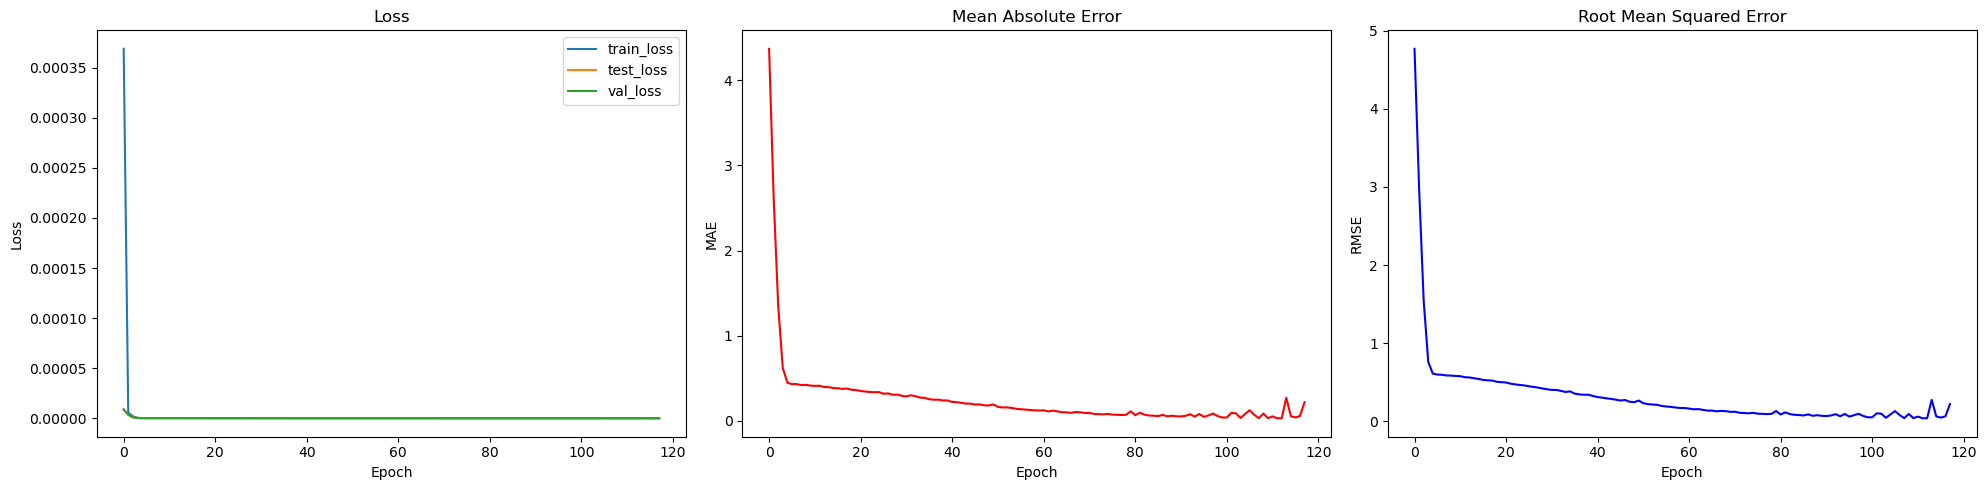

In [14]:
train_loss,val_loss,test_loss,mae,rmse=utile.train(t.denormalize,torch.optim.Adam,lr,torch.nn.HuberLoss(delta=2),LSTMModel(3,64,1,1),train_loader,val_loader,test_loader,epoch_num,device,batch_size,early_stop_len=5)
utile.show_result(train_loss,val_loss,test_loss,mae,rmse)

## 增加hidden_size

epoch: 1 
 train_loss: 2.170938192711471e-05 test_loss: 5.697985969803725e-07 val_loss: 5.616318850974899e-07 
 mae: 1.0474793 rmse: 1.2148316247360336
epoch: 2 
 train_loss: 2.3249709237891594e-07 test_loss: 1.5101825041525712e-07 val_loss: 1.8784561461870908e-07 
 mae: 0.50921524 rmse: 0.699262252494015
epoch: 3 
 train_loss: 1.60040241086286e-07 test_loss: 1.517173523603156e-07 val_loss: 1.806494667435901e-07 
 mae: 0.49371478 rmse: 0.6852508190412563
epoch: 4 
 train_loss: 1.5576588239867537e-07 test_loss: 1.458116203581186e-07 val_loss: 1.7630489634467704e-07 
 mae: 0.48588893 rmse: 0.6786353728187301
epoch: 5 
 train_loss: 1.5012779564618672e-07 test_loss: 1.4195873342680864e-07 val_loss: 1.704183242589318e-07 
 mae: 0.4787358 rmse: 0.6664267403587577
epoch: 6 
 train_loss: 1.456778423300464e-07 test_loss: 1.3781658770573846e-07 val_loss: 1.6372771990855081e-07 
 mae: 0.4692837 rmse: 0.6534852440300712
epoch: 7 
 train_loss: 1.4067236761260333e-07 test_loss: 1.282951095154877e-07

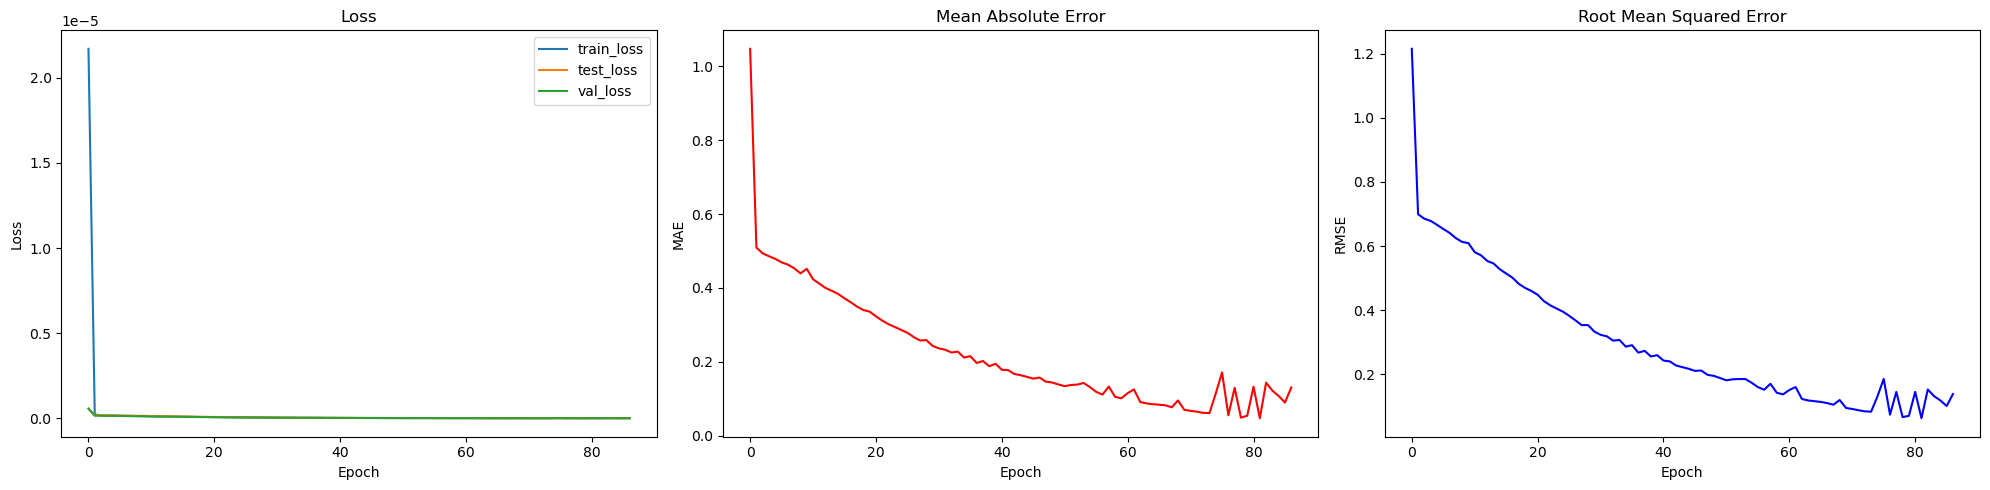

In [15]:
train_loss,val_loss,test_loss,mae,rmse=utile.train(t.denormalize,torch.optim.Adam,lr,torch.nn.HuberLoss(delta=2),LSTMModel(3,128,1,1),train_loader,val_loader,test_loader,epoch_num,device,batch_size,early_stop_len=5)
utile.show_result(train_loss,val_loss,test_loss,mae,rmse)

## 减少学习率

epoch: 1 
 train_loss: 3.906950611856273e-06 test_loss: 3.228305971518879e-07 val_loss: 3.3172764591216507e-07 
 mae: 0.78488106 rmse: 0.9327520033005293
epoch: 2 
 train_loss: 1.6190380523265772e-07 test_loss: 1.3308119143310386e-07 val_loss: 1.5693223655556788e-07 
 mae: 0.46146032 rmse: 0.6389098304497672
epoch: 3 
 train_loss: 1.3213780185166675e-07 test_loss: 1.2926208844040352e-07 val_loss: 1.5021633477848204e-07 
 mae: 0.4541302 rmse: 0.625943736818681
epoch: 4 
 train_loss: 1.2810536610089343e-07 test_loss: 1.2532436375909972e-07 val_loss: 1.4469589852221057e-07 
 mae: 0.44511172 rmse: 0.6133191917467299
epoch: 5 
 train_loss: 1.2242896345979025e-07 test_loss: 1.2086459332960185e-07 val_loss: 1.3998275039528853e-07 
 mae: 0.4332902 rmse: 0.6031622818673028
epoch: 6 
 train_loss: 1.167883502998382e-07 test_loss: 1.1349431248306616e-07 val_loss: 1.3159334652409935e-07 
 mae: 0.4236665 rmse: 0.5841886908403134
epoch: 7 
 train_loss: 1.1046519869110107e-07 test_loss: 1.068560819745

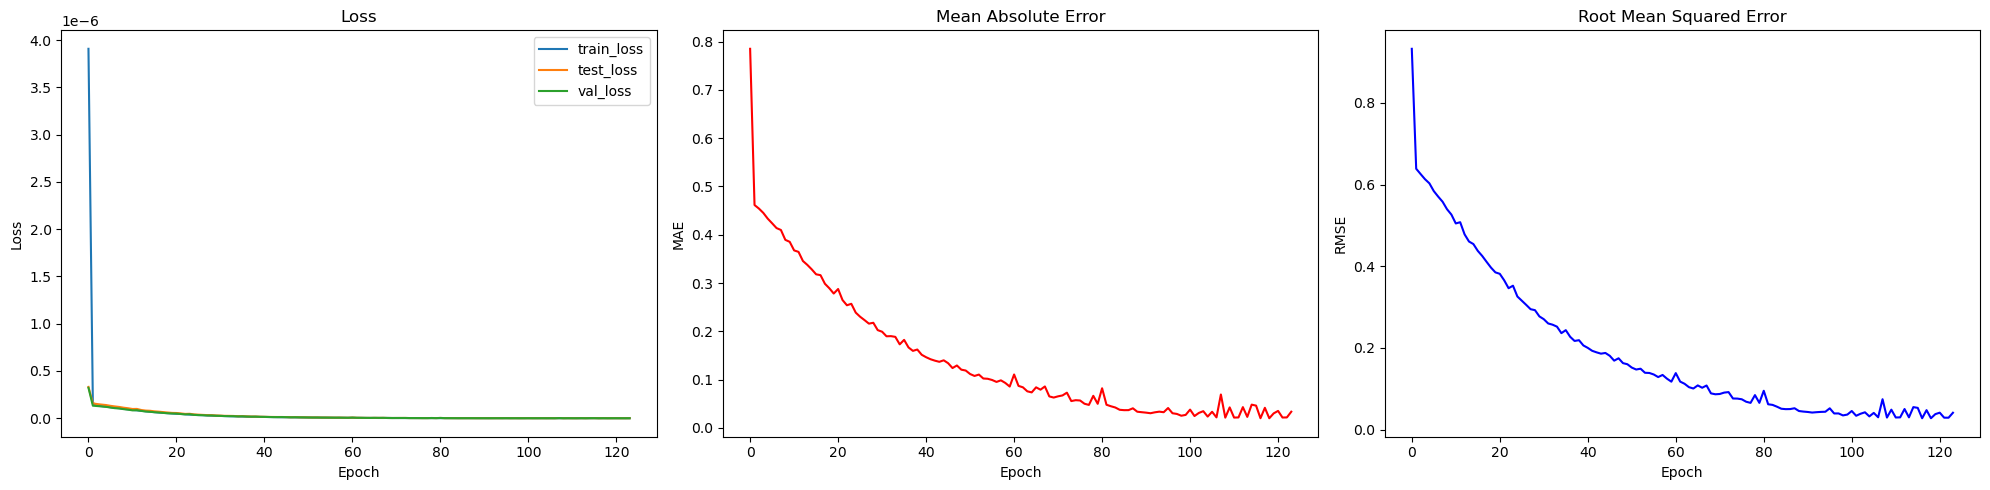

In [16]:
train_loss,val_loss,test_loss,mae,rmse=utile.train(t.denormalize,torch.optim.Adam,0.5*lr,torch.nn.HuberLoss(delta=2),LSTMModel(3,64,1,1),train_loader,val_loader,test_loader,epoch_num,device,batch_size,early_stop_len=5)
utile.show_result(train_loss,val_loss,test_loss,mae,rmse)

## 结果分析